In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.axes
import numpy as np
from scipy import signal
from typing import Callable
import heapq

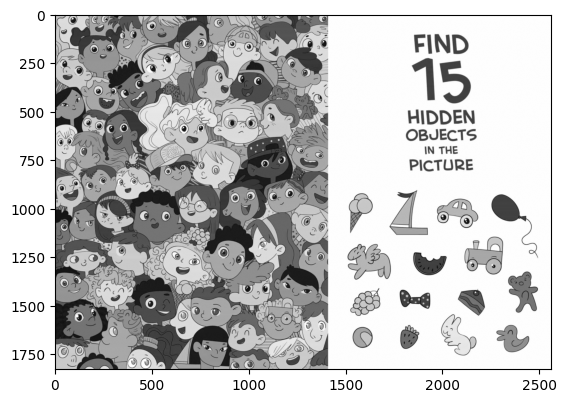

In [2]:
img = cv2.imread("1.jpg")
img = img[:, :, 1]
plt.imshow(img, cmap="gray")

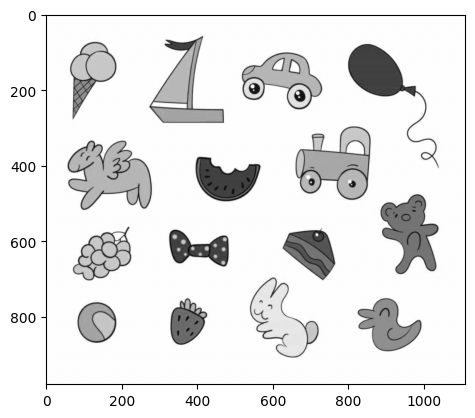

In [3]:
OBJECT_IMG = img[850:, 1450:]
TARGET_IMG = img[:, :1400]
plt.imshow(OBJECT_IMG, cmap="gray")
plt.show()
# plt.imshow(target_img, cmap="gray")
# plt.show()

In [4]:
def extract_single(object_img: np.ndarray, threshold: int = 0, step: int = 4):
    # print(object_img[0, 0])
    img_h, img_w = object_img.shape
    detected_x = -1
    detected_y = -1
    for x in range(img_w):
        for y in range(img_h):
            if object_img[y, x] < threshold:
                detected_x = x
                detected_y = y
                break
        if detected_x != -1:
            break
    left_x = detected_x
    right_x = detected_x
    up_y = detected_y
    down_y = detected_y
    def check_complete(left: int, right: int, up: int, down: int):
        line1 = object_img[up, left:right]
        line2 = object_img[down, left:right]
        line3 = object_img[up:down, left]
        line4 = object_img[up:down, right]
        border = list(line1) + list(line2) + list(line3) + list(line4)
        if len(border) == 0: return False
        return all(v > threshold for v in border)
    interation = 0
    while not check_complete(left_x, right_x, up_y, down_y):
        if interation == 0 or not all(v > threshold for v in object_img[up_y:down_y, left_x]):
            while True:
                left_x = max(0, left_x-step)
                if left_x == 0: break
                arr_range = list(object_img[up_y:down_y, left_x-step:left_x].flatten())
                if all(v > threshold for v in arr_range): break
        if interation == 0 or not all(v > threshold for v in object_img[up_y:down_y, right_x]):
            while True:
                right_x = min(img_w-1, right_x+step)
                if right_x == img_w - 1: break
                arr_range = list(object_img[up_y:down_y, right_x:right_x+step].flatten())
                if all(v > threshold for v in arr_range): break
        if interation == 0 or not all(v > threshold for v in object_img[up_y, left_x:right_x]):
            while True:
                up_y = max(0, up_y-step)
                if up_y == 0: break
                arr_range = list(object_img[up_y-step:up_y, left_x:right_x].flatten())
                if all(v > threshold for v in arr_range): break
        if interation == 0 or  not all(v > threshold for v in object_img[down_y, left_x:right_x]):
            while True:
                down_y = min(img_h-1, down_y+step)
                if down_y == img_h - 1: break
                arr_range = list(object_img[down_y:down_y+step, left_x:right_x].flatten())
                if all(v > threshold for v in arr_range): break
        interation += 1
        if interation > 100: break
    print(interation, left_x, up_y, right_x, down_y)
    return object_img[up_y:down_y, left_x:right_x], (left_x, right_x, up_y, down_y)
def extract(object_image: np.ndarray, threshold: int = 0, step: int = 4, amount: int = 15):
    img = object_image.copy().astype(np.int32)
    object_images: list[np.ndarray] = []
    for _ in range(amount):
        object_img, (left, right, up, down) = extract_single(img, threshold, step)
        object_images.append(object_img.copy())
        img[up:down, left:right] = 255
    return object_images

3 48 332 288 524
2 55 67 191 283
3 63 559 231 711
2 75 756 187 876
2 265 50 473 290
2 317 568 485 672
2 320 745 432 881
2 387 370 571 498
2 509 95 733 255
4 530 563 770 915
2 651 293 859 493
5 790 76 1038 412
3 815 747 999 899
3 875 473 1043 689
(192, 240)


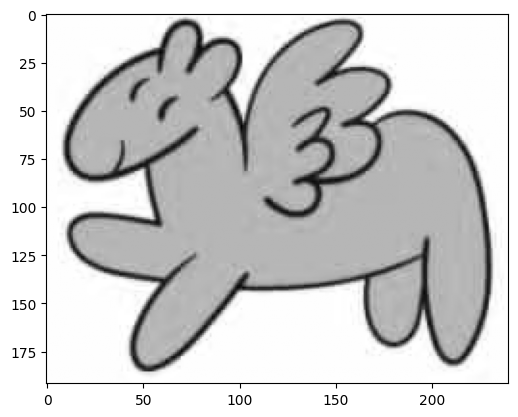

(216, 136)


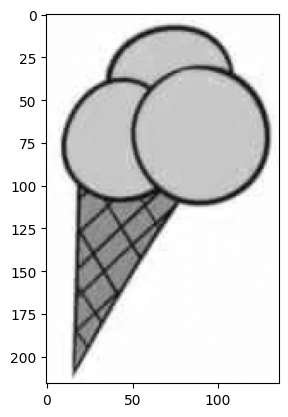

(152, 168)


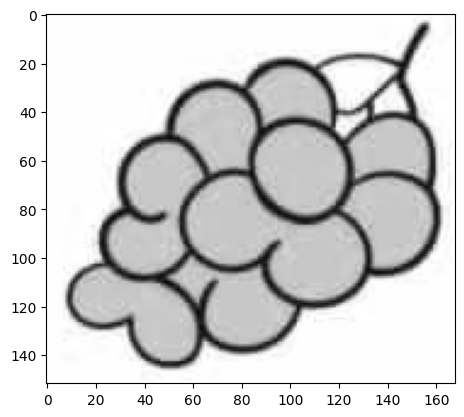

(120, 112)


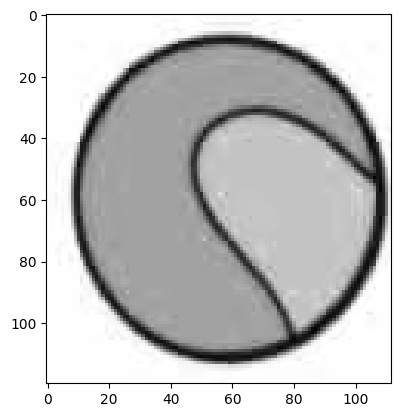

(240, 208)


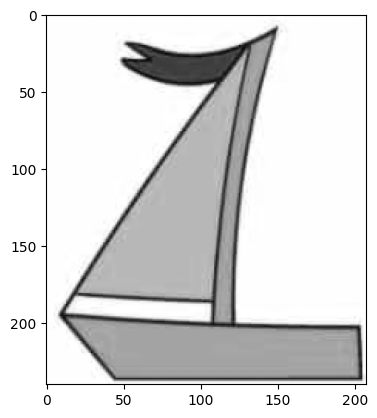

(104, 168)


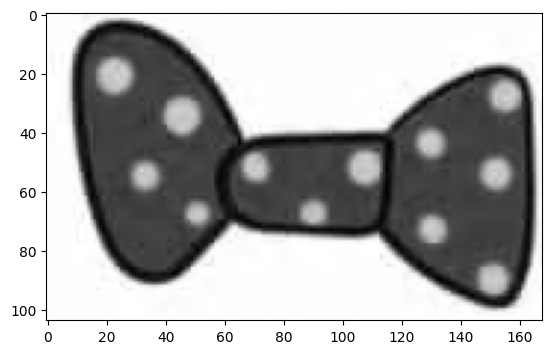

(136, 112)


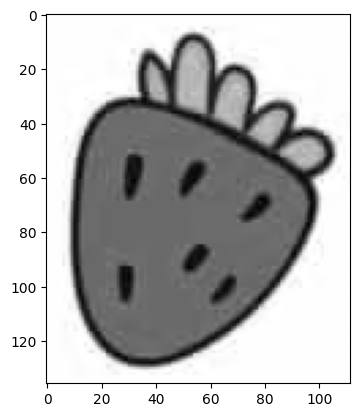

(128, 184)


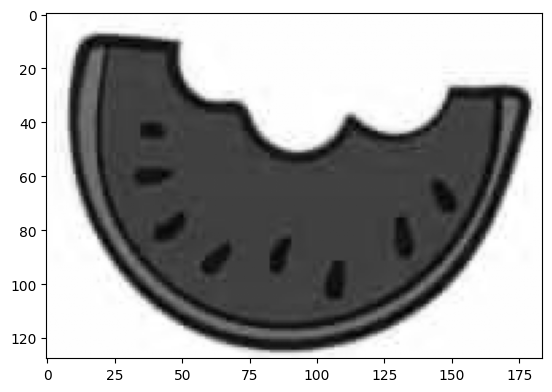

(160, 224)


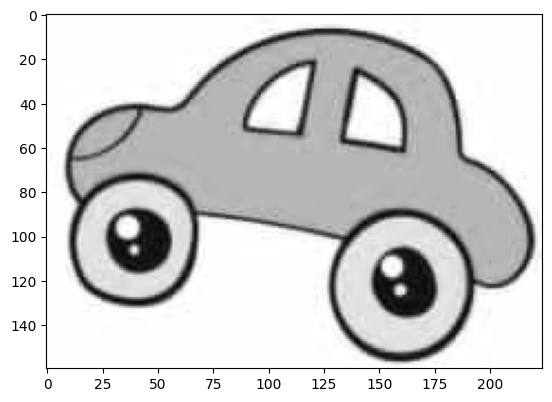

(352, 240)


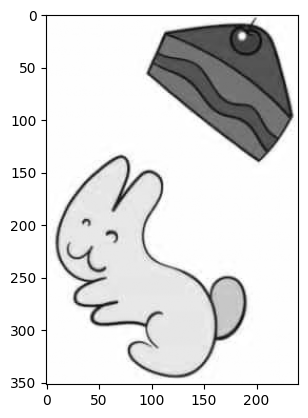

(200, 208)


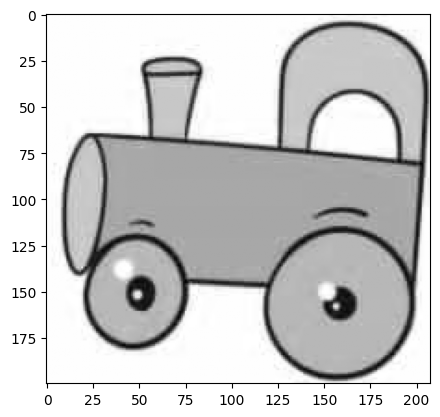

(336, 248)


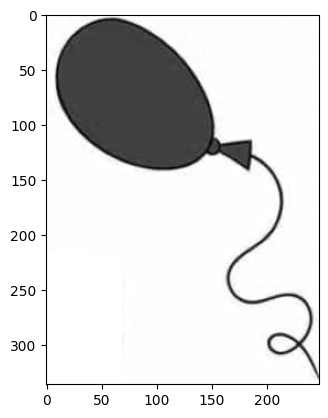

(152, 184)


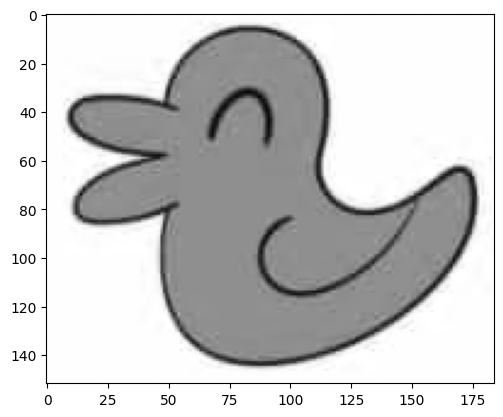

(216, 168)


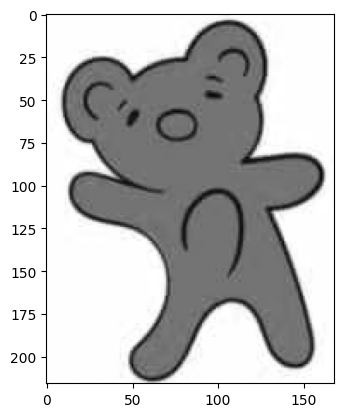

In [5]:
# extracted_img, _ = extract_single(OBJECT_IMG.astype(np.int32), 250, 4)
OBJECT_IMGS = extract(OBJECT_IMG, 230, 8, 14)
for extracted_img in OBJECT_IMGS:
    print(extracted_img.shape)
    plt.imshow(extracted_img, cmap="gray")
    plt.show(True)
# for i in range(min(extracted_img.shape[0], 100)):
#     row = ""
#     for j in range(min(extracted_img.shape[1], 100)):
#         row += f"{extracted_img[i, j]} "
#     print(row)

In [6]:
def calculate_histogram(img: np.ndarray) -> np.ndarray:
    return cv2.calcHist([img.astype(np.uint8)], channels=[0], mask=None, histSize=[256], ranges=[0, 256])

In [7]:
def cosine_simmilarity(arr1: np.ndarray, arr2: np.ndarray) -> float:
    flat1 = arr1.flatten()
    flat2 = arr2.flatten()
    return np.dot(flat1, flat2) / (np.linalg.norm(flat1) * np.linalg.norm(flat2))
def cosine_simmilarity_hist(arr1: np.ndarray, arr2: np.ndarray) -> float:
    flat1 = calculate_histogram(arr1).flatten()
    flat2 = calculate_histogram(arr2).flatten()
    return np.dot(flat1, flat2) / (np.linalg.norm(flat1) * np.linalg.norm(flat2))
def cosine_simmilarity_hist_2(arr1: np.ndarray, arr2: np.ndarray) -> float:
    flat1 = calculate_histogram(arr1).flatten()[1:]
    flat2 = calculate_histogram(arr2).flatten()[1:]
    return np.dot(flat1, flat2) / (np.linalg.norm(flat1) * np.linalg.norm(flat2))
def hist_simmilarity_relative(patch: np.ndarray, template: np.ndarray) -> float:
    patch_hist = calculate_histogram(patch).flatten()[1:]
    max_index = np.argmax(patch_hist)
    max_value = patch_hist[max_index]
    template_hist = calculate_histogram(template).flatten()[1:]
    template_hist = tuple(template_hist / max_value)
    patch_hist = tuple(patch_hist / max_value)
    sim = 0
    for i in range(len(template_hist)):
        value_sim = (template_hist[i] - patch_hist[i]) ** 2 * template_hist[i]
        sim += value_sim
    return sim

In [8]:
def compute(func: Callable[[np.ndarray, np.ndarray], float], img: np.ndarray, template: np.ndarray, stride: int):
    img_h, img_w = img.shape[:2]
    temp_h, temp_w = template.shape[:2]
    res_h = (img_h-temp_h)//stride + 1
    res_w = (img_w-temp_w)//stride + 1
    result = np.zeros((res_h, res_w))
    for y in range(res_h):
        for x in range(res_w):
            patch = img[y*stride:y*stride + temp_h, x*stride:x*stride + temp_w]
            # print(f"{patch.shape} {template.shape}")
            simmilarity = func(patch, template)
            result[y, x] = simmilarity
    return result
def detect_area(mask: np.ndarray, region_size: tuple[int, int], region_pad: tuple[int, int] = (0, 0), num_result: int = 1, is_min: bool = True):
    local_mask = mask.copy()
    if not is_min:
        local_mask *= -1
    detected_mask = np.zeros_like(mask).astype(bool)
    detected_mask[:, :] = False
    pq = []
    mask_h, mask_w = mask.shape[:2]    
    for y in range(mask_h):
        for x in range(mask_w):
            heapq.heappush(pq, (local_mask[y, x], (y, x)))
    result = []
    while len(pq) > 0 and len(result) < num_result:
        _, (y, x) = heapq.heappop(pq)
        if detected_mask[y, x]: continue
        # print(_, y , x)
        detected_mask[max(0, y-region_pad[0]): min(mask_h-1, y+region_size[0]+region_pad[0]), max(0, x-region_pad[1]): min(mask_w-1, x+region_size[1]+region_pad[1])] = True
        result.append((y, x))
    return result

In [9]:
def draw_bound(img: np.ndarray, top: int, down: int, left: int, right: int, size: int, color: int | np.ndarray):
    img[top:down, left-size//2:left+size//2] = color
    img[top:down, right-size//2:right+size//2] = color
    img[top-size//2:top+size//2, left:right] = color
    img[down-size//2:down+size//2, left:right] = color
    return img
def process_single_object(img: np.ndarray, template: np.ndarray, stride: int):
    _, axes = plt.subplots(1, 4, figsize=(12, 3))
    axes: list[matplotlib.axes.Axes]
    ax_template_image = axes[0]
    ax_template_image.set_title("Template image")
    ax_template_image.axis("off")
    ax_template_hist = axes[1]
    ax_template_hist.set_title("Template histogram")
    ax_result_image = axes[2]
    ax_result_image.set_title("Result heatmap")
    ax_result_image.axis("off")
    ax_result_value = axes[3]
    ax_result_value.set_title("Result value")
    # ax_detected_area = axes[4]
    # ax_detected_area.set_title("Detected area")
    # ax_detected_area.axis("off")
    plt.tight_layout()

    template[template > 225] = 0
    hist = calculate_histogram(template)[1:]
    result = compute(cosine_simmilarity_hist, img, template, stride)
    region_size = (192//stride, 240//stride)
    detected_position = detect_area(result, region_size, region_pad=(32, 32), num_result=1, is_min=False)
    # count, mask = count_match(result, 0.999, (192//stride, 240//stride), True)
    # mask = mask.astype(int)
    detected_img = img.copy().astype(np.uint8)
    for (y, x) in detected_position:
        # detected_img[y*stride:(y+region_size[0])*stride, x*stride:(x+region_size[1])*stride] = 255
        detected_img = draw_bound(img, y*stride, (y+region_size[0])*stride, x*stride, (x+region_size[1])*stride, 4, 0)
    ax_template_image.imshow(template, cmap="gray")
    ax_template_hist.plot(hist)
    ax_result_image.imshow(result, cmap="gray")
    ax_result_value.plot(result.flatten())
    # ax_detected_area.imshow(detected_img, cmap="gray")
    
    plt.show(True)
    plt.imshow(detected_img, cmap="gray")
    plt.show(True)

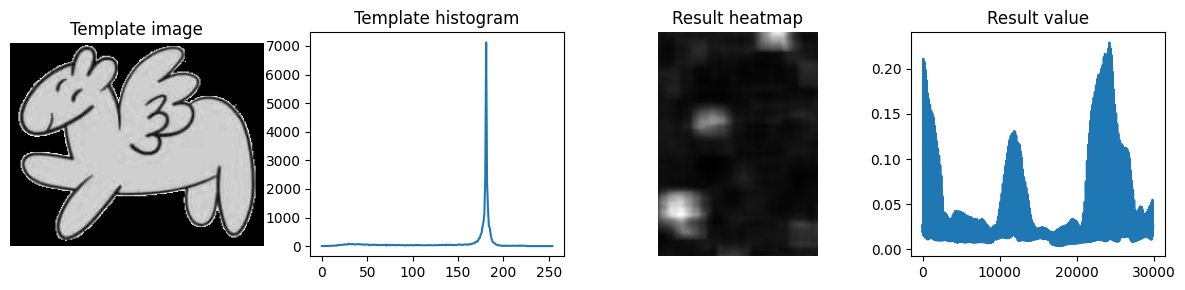

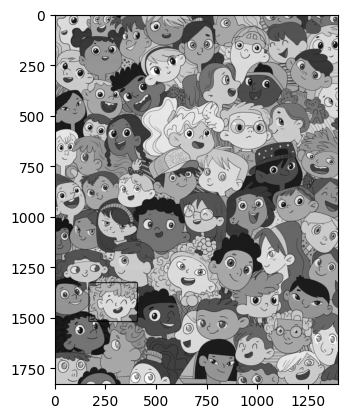

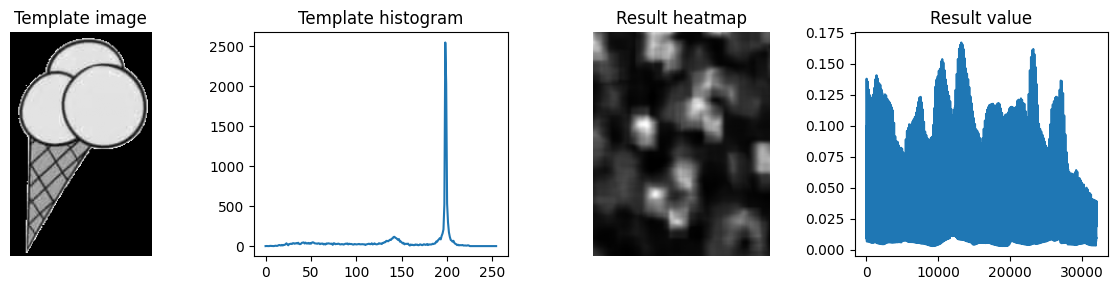

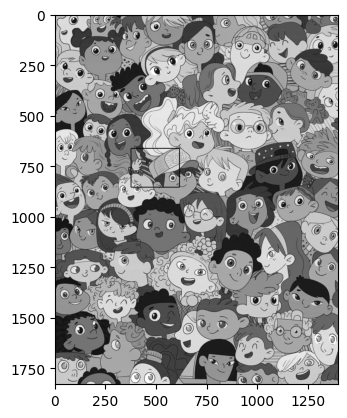

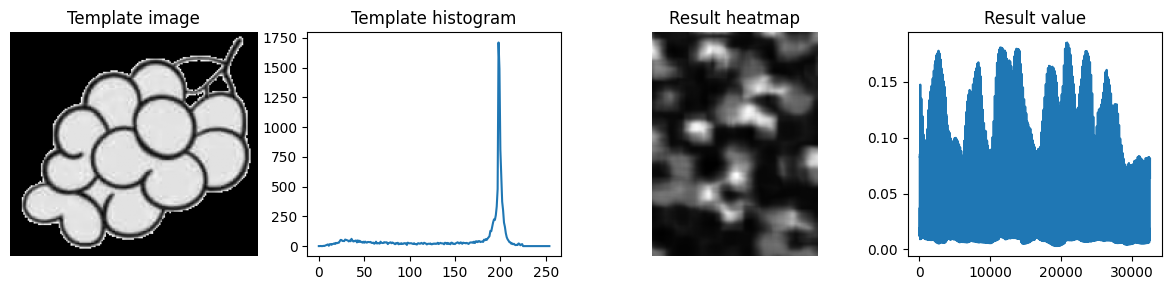

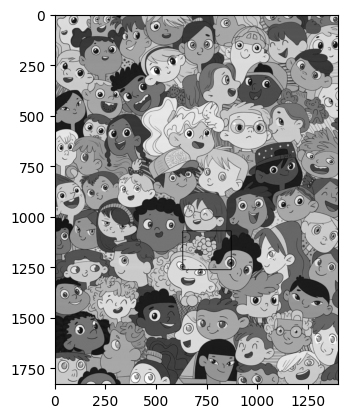

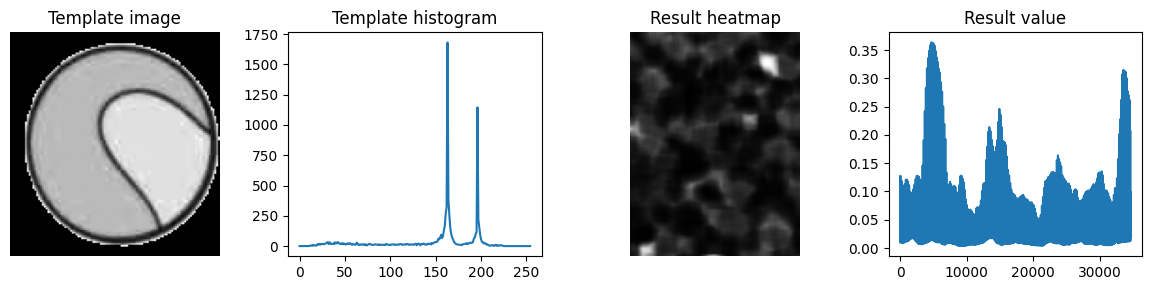

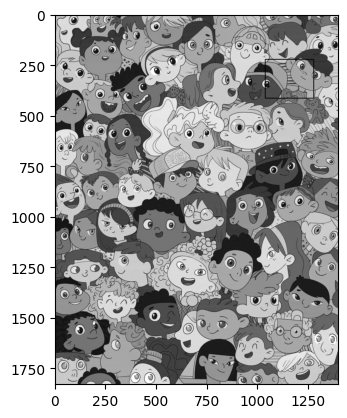

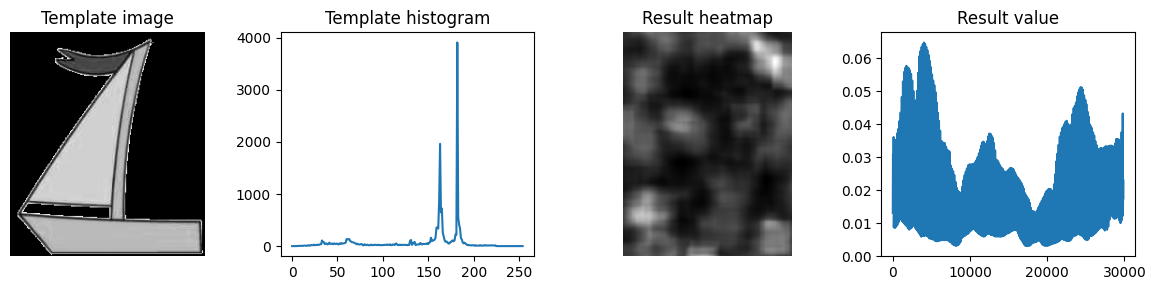

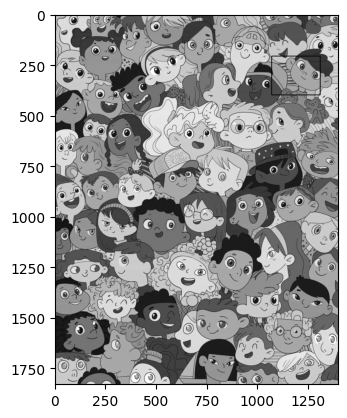

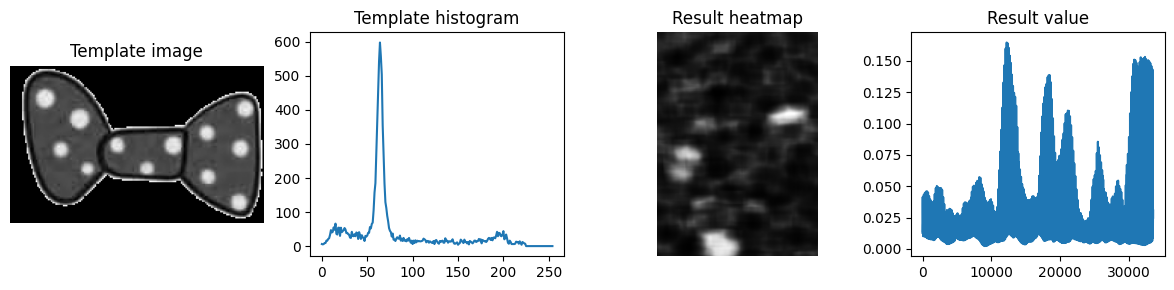

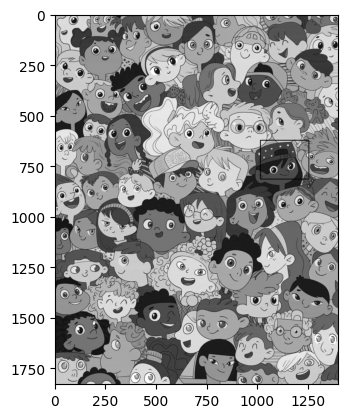

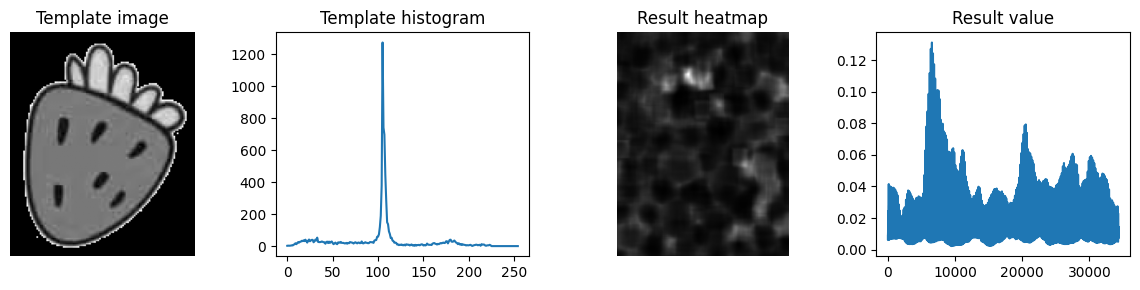

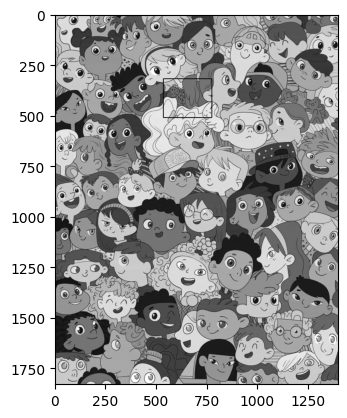

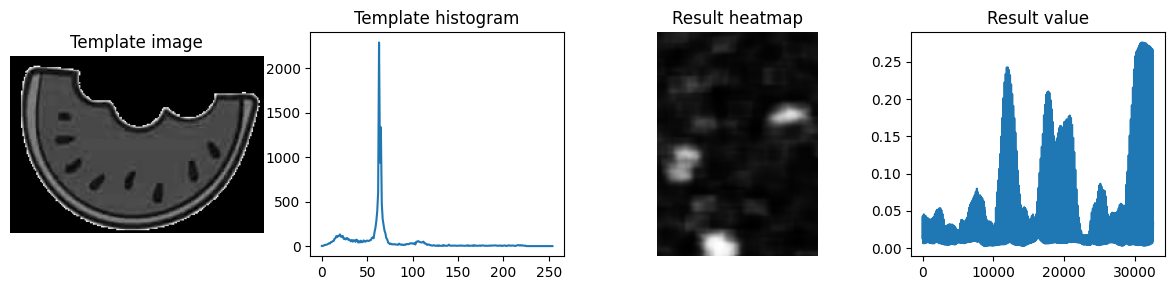

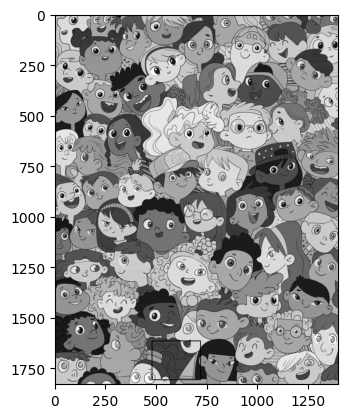

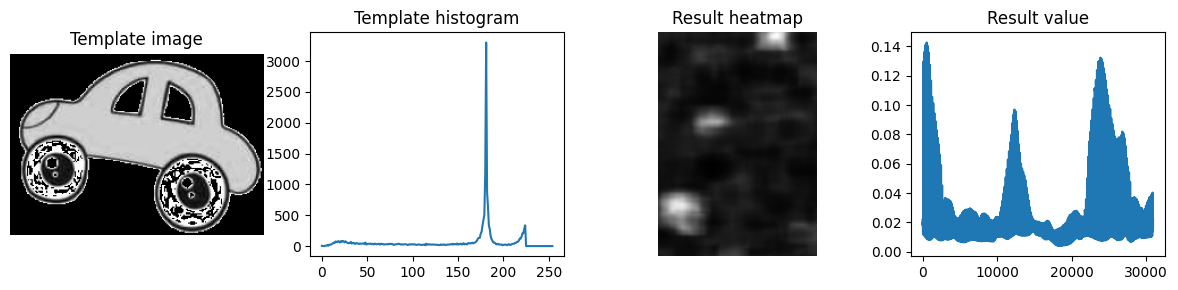

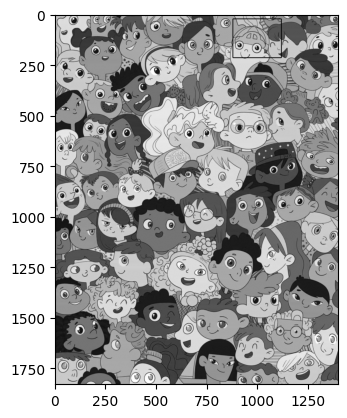

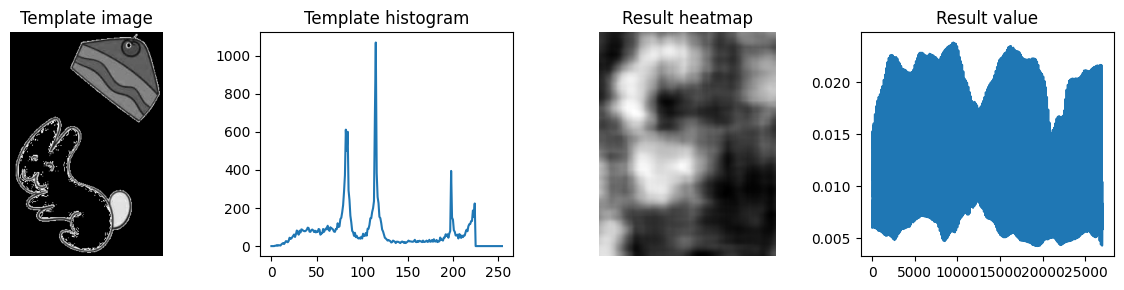

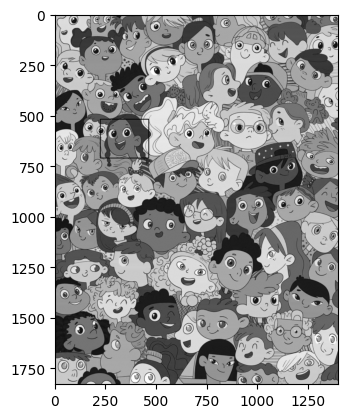

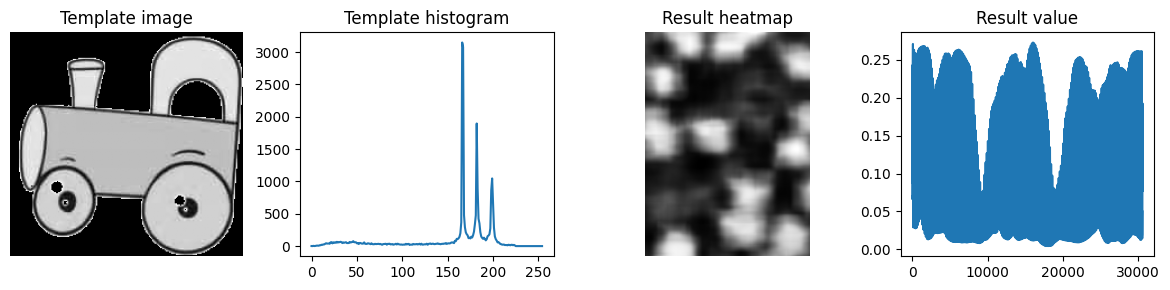

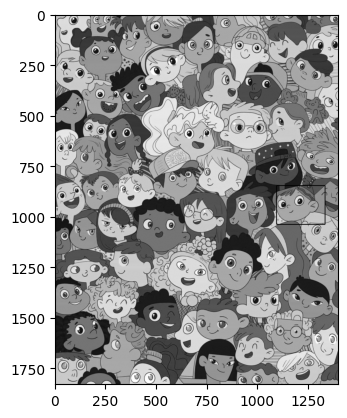

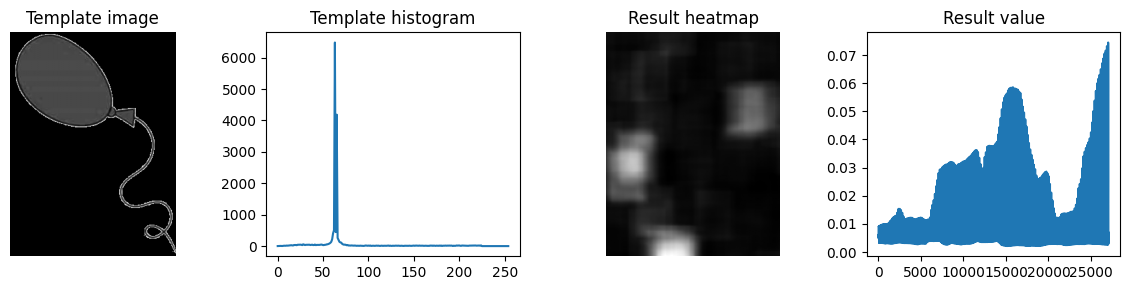

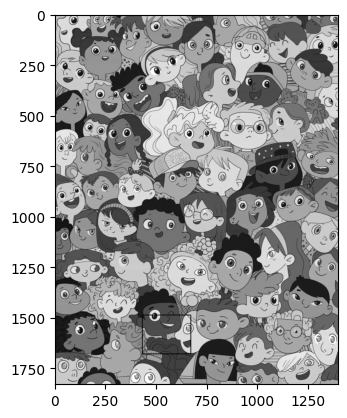

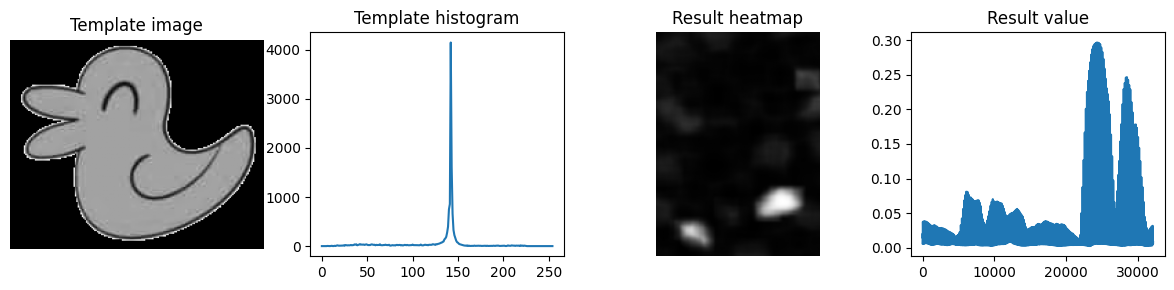

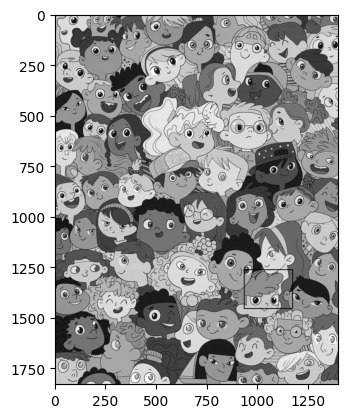

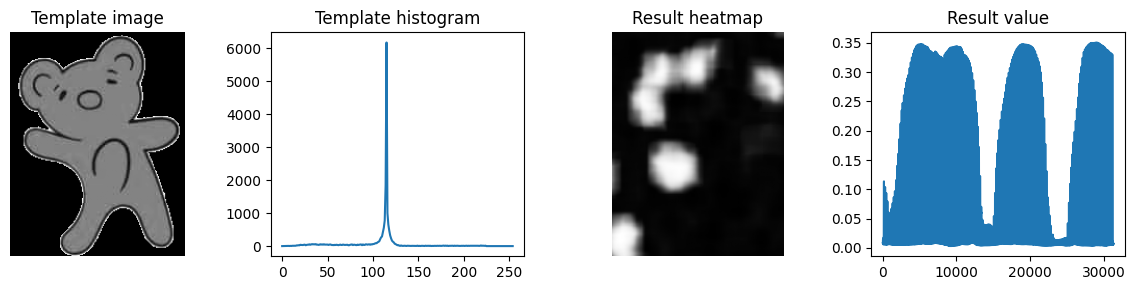

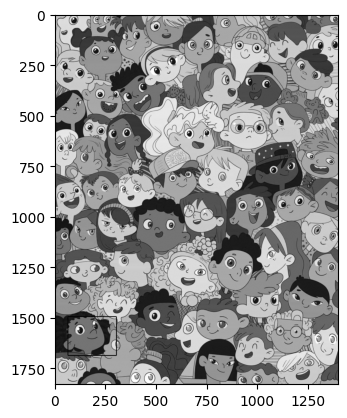

In [10]:
for template in OBJECT_IMGS:
    process_single_object(TARGET_IMG.copy(), template.copy(), 8)
